In [131]:
import numpy as np
np.random.seed(1234)
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from sklearn.manifold.t_sne import _joint_probabilities

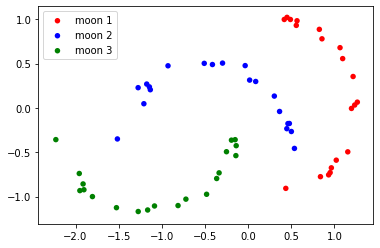

In [73]:
N = 20
t = np.random.rand(N) * np.pi
t.sort()

moon1 = np.column_stack((np.sin(t)+0.25, np.cos(t))) + 0.05 * np.random.randn(N,2)
moon2 = np.column_stack((np.cos(t), np.sin(t))) + 0.05 * np.random.randn(N,2) - 0.5
moon3 = np.column_stack((np.cos(t)-1.2, -np.sin(t)-0.2)) + 0.05 * np.random.randn(N,2)
moons = np.concatenate((moon1, moon2, moon3), 0)

m1 = plt.scatter(moon1[:,0], moon1[:,1], s=30, facecolors='r', edgecolors='none')
m2 = plt.scatter(moon2[:,0], moon2[:,1], s=30, facecolors='b', edgecolors='none')
m3 = plt.scatter(moon3[:,0], moon3[:,1], s=30, facecolors='g', edgecolors='none')
plt.legend((m1,m2,m3), ('moon 1', 'moon 2', 'moon 3'))
plt.show()

In [74]:
size = moons.shape[0] # size of the data

In [75]:
from sklearn.metrics import pairwise_distances
distances = pairwise_distances(moons, metric='euclidean',squared=True)
# distances is a symmtric matrix, by definition
# all elements in distances are already squared

In [76]:
moonvariance = np.var(moons, axis=1)
# compute matrix P
P = np.zeros((size, size))

# Denominator is the sum of many exponentials of the distances, except the diagonal terms
for i in range(0, size):
    denominator = 0
    for k in range(0, size):
        denominator += np.exp(-distances[i][k] /2 /moonvariance[i])
    for j in range(0, size):
        P[j][i] = np.exp(-distances[i][j] /2 /moonvariance[i]) / denominator

In [111]:
# compute matrix ~P
P2 = np.zeros((size, size))
for i in range(0, size):
    for j in range(0, size):
        P2[i][j] = (P[i][j] + P[j][i]) /2 /size

squareform(P2)
### Here, because the diagonal terms of P2 are not 0, P2 cannot be converted to a square form

array([0.00295723, 0.00290615, 0.00291667, ..., 0.0019111 , 0.00106263,
       0.00131157])

In [79]:
def KL_divergence(params, *args):
    P, n_samples, n_features = args
    # params are y, need to learn
    # P is matrix P
    # n_samples, number of rows of the matrix data
    # n_features, number of columns of the matrix data
    MACHINE_EPSILON = np.finfo(np.double).eps
    
    Y = params.reshape(n_samples, n_components)
    
    distances = pairwise_distances(Y, metric='euclidean',squared=True) # NOTICE: distances are already squared
    Q = np.zeros((n_samples, n_samples))
    
    denominator = 0 # the denominator of all elements of Q
    for i in range(0, n_samples):
        for j in range(0, n_samples):
            if i != j:
                denominator += 1/(1+distances[i][j])

    for i in range(0, n_samples):
        for j in range(0, n_samples):
            Q[i][j] = np.maximum(1/(1+distances[i][j]) / denominator, MACHINE_EPSILON)
    
    
    kl_div = 0
    for i in range(0, n_samples):
        for j in range(0, n_samples):
            kl_div += P[i][j] * np.log(np.maximum(P[i][j], MACHINE_EPSILON)/Q[i][j])

    return kl_div

def grad_KL_div(params, *args):
    P, n_samples, n_features = args
    # params are y, need to learn
    # P is matrix P
    # n_samples, number of rows of the matrix data
    # n_features, number of columns of the matrix data
    
    Y = params.reshape(n_samples, n_components)
    
    distances = pairwise_distances(Y, metric='euclidean',squared=True) # NOTICE: distances are already squared
    Q = np.zeros((n_samples, n_samples))
    
    denominator = 0 # the denominator of all elements of Q
    for i in range(0, n_samples):
        for j in range(0, n_samples):
            if i != j:
                denominator += 1/(1+distances[i][j])

    for i in range(0, n_samples):
        for j in range(0, n_samples):
            Q[i][j] = np.maximum(1/(1+distances[i][j]) / denominator, MACHINE_EPSILON)
    
    # gradient
    grad = np.zeros((n_samples, n_components))
    
    for i in range(0, n_samples):
        # calculate grad[i]
        for j in range(0, n_samples):
            grad[i] += 4* (Y[i] - Y[j]) * (P[i][j] - Q[i][j]) / (1+distances[i][j])
    
    grad = grad.ravel()
    return grad

In [113]:
def KL_divergence(params, *args):
    P, n_samples, n_features = args
    # params are y, need to learn
    # P is matrix P.ravel()
    # n_samples, number of rows of the matrix data
    # n_features, number of columns of the matrix data
    MACHINE_EPSILON = np.finfo(np.double).eps
    
    Y = params.reshape(n_samples, n_components)
    
    distances = pdist(Y, "sqeuclidean") # NOTICE: distances are already squared
    distances += 1
    Q = np.maximum(distances /2.0 /np.sum(distances), MACHINE_EPSILON)
    
    kl_div = 2.0 * np.dot(P, np.log(np.maximum(P, MACHINE_EPSILON) / Q))
    
    return kl_div


def grad_KL_div(params, *args):
    P, n_samples, n_features = args
    # params are y, need to learn
    # P is matrix P
    # n_samples, number of rows of the matrix data
    # n_features, number of columns of the matrix data
    MACHINE_EPSILON = np.finfo(np.double).eps
    
    Y = params.reshape(n_samples, n_components)
    
    distances = pdist(Y, "sqeuclidean") # NOTICE: distances are already squared
    distances += 1
    Q = np.maximum(distances /2.0 /np.sum(distances), MACHINE_EPSILON)
    
    # gradient
    grad = np.ndarray((n_samples, n_components), dtype=params.dtype)
    PQd = squareform((P - Q) * distances)
    for i in range(1, n_samples):
        grad[i] = np.dot(np.ravel(PQd[i], order='K'), Y[i] - Y)
    grad = grad.ravel()
    
    return grad

In [48]:
from scipy import optimize

In [114]:
args = squareform(P2), size, 1

y0 = np.random.rand(size) / 100
res1 = optimize.fmin_cg(KL_divergence, y0, fprime=grad_KL_div, args=args)

(3600,)
         Current function value: 0.848165
         Iterations: 1
         Function evaluations: 21
         Gradient evaluations: 20


In [115]:
res1

array([2.18943076e-05, 4.19652446e-04, 1.41787383e-03, 5.98237185e-03,
       1.06460522e-03, 2.97158986e-03, 5.83919899e-04, 6.21324860e-03,
       2.26804761e-04, 8.55054686e-03, 3.06337203e-03, 7.58783445e-03,
       5.63275110e-03, 3.81641822e-04, 5.65516724e-03, 6.58873489e-03,
       1.83266349e-03, 7.97411308e-03, 6.12367429e-03, 5.55653384e-03,
       6.29491545e-03, 6.86180075e-03, 2.40382538e-03, 7.87927788e-03,
       8.56477457e-03, 7.27796016e-03, 6.92345143e-03, 4.72350939e-03,
       8.56872942e-03, 6.64743334e-03, 3.33375942e-03, 5.18145499e-03,
       3.94688583e-03, 3.10495984e-04, 5.76839843e-03, 8.50251745e-03,
       9.51488865e-03, 6.82978797e-03, 7.61625482e-04, 4.10077943e-03,
       4.19013988e-04, 1.74186832e-03, 5.65402006e-03, 1.72891171e-03,
       5.66610478e-03, 5.14004253e-03, 8.68870888e-03, 7.20347248e-03,
       9.03591347e-03, 2.77614998e-03, 2.56665432e-03, 6.99703263e-03,
       9.01568896e-03, 9.83692325e-03, 6.40912812e-03, 3.30007389e-03,
      

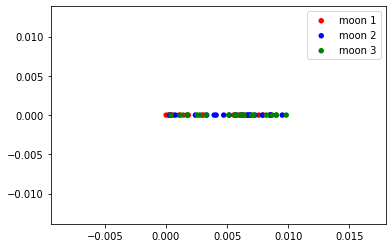

In [128]:
a = np.arange(0,N)
b = np.arange(N,N*2)
c = np.arange(N*2,N*3)
y = np.zeros(N)

m1 = plt.scatter(res1[a], y, s=30, facecolors='r', edgecolors='none')
m2 = plt.scatter(res1[b], y, s=30, facecolors='b', edgecolors='none')
m3 = plt.scatter(res1[c], y, s=30, facecolors='g', edgecolors='none')
plt.legend((m1,m2,m3), ('moon 1', 'moon 2', 'moon 3'))
plt.show()

In [127]:
np.arange(N+1,N*2).shape

(19,)

In [4]:
np.asarray((1,2))

array([1, 2])

In [10]:
a = np.array([[1, 2], [10, 10]])
np.var(a, axis=1)

array([0.25, 0.  ])

In [14]:
np.var(moons, axis=1).shape

(600,)

In [36]:
np.zeros((n_samples, n_components)) + 1

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],